# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json

# regression
import seaborn as sns
from scipy import stats as st

# linear modelling
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

In [3]:
# Output File (CSV)
output_data_file = "output_data/cities_booth.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [4]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

584

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [5]:
cities[0:5]

['belushya guba', 'zhangye', 'saint-philippe', 'hilo', 'rikitea']

In [8]:
rows = []

for i in range(len(cities)):
    city = cities[i]
    
    # only print every 50th city
    if i % 50 == 0:
        print()
        print(f"Index: {i}, City: {city}")
    
    row = {}
    try:
    
        # get the geocode, lat and long
        url = f"http://api.openweathermap.org/geo/1.0/direct?q={city}&appid={weather_api_key}"
        response = requests.get(url)

        if (response.status_code == 200):
            data = response.json()

            # parse data
            if (len(data) > 0):
                lat = data[0]["lat"]
                lon = data[0]["lon"]

                # make second request to get weather
                url2 = f'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={weather_api_key}&units=imperial'
                response2 = requests.get(url2)

                if (response2.status_code == 200):
                    data2 = response2.json()

                    # parse data
                    weather = data2["weather"][0]["main"]
                    temp = data2["main"]["temp"]
                    humid = data2["main"]["humidity"]
                    pressure = data2["main"]["pressure"]
                    wind = data2["wind"]["speed"]
                else:
                    print(f"Weather request failed for {city}")
                    weather = None
                    temp = np.nan
                    humid = np.nan
                    pressure = np.nan
                    wind = np.nan

                # put into flat dictionary
                row["city"] = city
                row["latitude"] = lat
                row["longitude"] = lon
                row["weather"] = weather
                row["temperature"] = temp
                row["humidity"] = humid
                row["pressure"] = pressure
                row["wind_speed"] = wind

                # append to list
                rows.append(row)

            else:
                print(f"no lat/long for {city}")
                pass
        else:
            print(f"failed request for geocode for {city}")
            pass
    except Exception as e:
        print(e)
        print(f"Oh no! Everything failed and broke for {city}. There should be an error above. Sux")
        print()
        
    # sleep
    time.sleep(2)


Index: 0, City: belushya guba
no lat/long for beringovskiy
no lat/long for taolanaro

Index: 50, City: grand-santi
no lat/long for cherskiy
no lat/long for tabiauea

Index: 100, City: pevek
no lat/long for meyungs
no lat/long for chagda

Index: 150, City: revelstoke

Index: 200, City: labuhan
no lat/long for novyy urengoy
no lat/long for saleaula
no lat/long for sembakung
no lat/long for kawana waters
no lat/long for sentyabrskiy

Index: 250, City: soe

Index: 300, City: port blair
no lat/long for dzhusaly
no lat/long for idenao
no lat/long for nizhniy odes

Index: 350, City: barentsburg
no lat/long for lolua

Index: 400, City: besenyotelek
no lat/long for kannangad
no lat/long for yar-sale
no lat/long for kedrovyy

Index: 450, City: kapit
no lat/long for inderborskiy

Index: 500, City: inuvik
no lat/long for staryy nadym

Index: 550, City: areni
no lat/long for vradiyivka
no lat/long for bardiyah


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [9]:
df = pd.DataFrame(rows)
df.head()

,city,latitude,longitude,weather,temperature,humidity,pressure,wind_speed
0,belushya guba,71.537698,52.342734,Clouds,19.02,90,1012,3.38
1,zhangye,38.936513,100.455633,Clear,38.43,37,1016,5.26
2,saint-philippe,45.358450,-73.479005,Clear,42.69,46,1038,13.80
3,hilo,19.707373,-155.081580,Rain,76.28,82,1021,6.91
4,rikitea,-23.122954,-134.968014,Clouds,75.54,89,1015,14.25


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         562 non-null    object 
 1   latitude     562 non-null    float64
 2   longitude    562 non-null    float64
 3   weather      562 non-null    object 
 4   temperature  562 non-null    float64
 5   humidity     562 non-null    int64  
 6   pressure     562 non-null    int64  
 7   wind_speed   562 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 35.2+ KB


In [11]:
df.to_csv(output_data_file, index=False)

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [12]:
df = pd.read_csv(output_data_file)
df.head()

,city,latitude,longitude,weather,temperature,humidity,pressure,wind_speed
0,belushya guba,71.537698,52.342734,Clouds,19.02,90,1012,3.38
1,zhangye,38.936513,100.455633,Clear,38.43,37,1016,5.26
2,saint-philippe,45.358450,-73.479005,Clear,42.69,46,1038,13.80
3,hilo,19.707373,-155.081580,Rain,76.28,82,1021,6.91
4,rikitea,-23.122954,-134.968014,Clouds,75.54,89,1015,14.25


In [13]:
#  Get the indices of cities that have humidity over 100%.
mask = df.humidity > 100
df.loc[mask]

,city,latitude,longitude,weather,temperature,humidity,pressure,wind_speed


In [ ]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

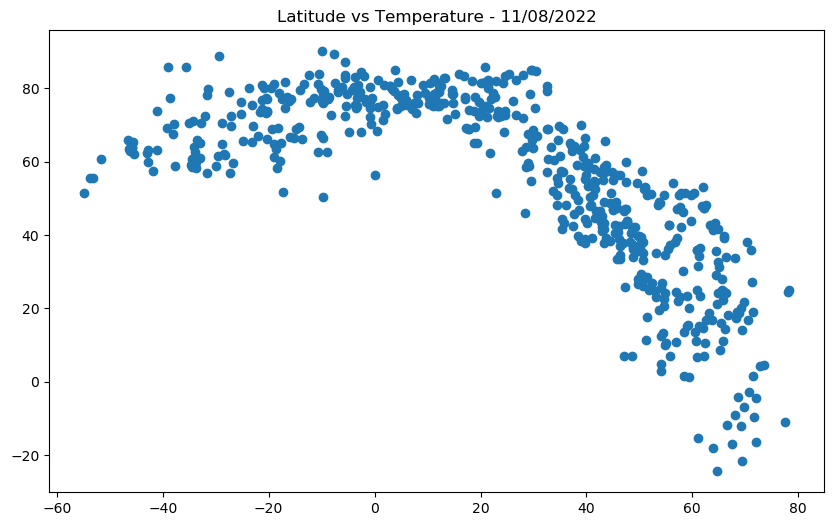

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(df.latitude, df.temperature)
plt.title("Latitude vs Temperature - 11/08/2022")
plt.show()

## Latitude vs. Humidity Plot

## Latitude vs. Cloudiness Plot

## Latitude vs. Wind Speed Plot

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7285852412623343


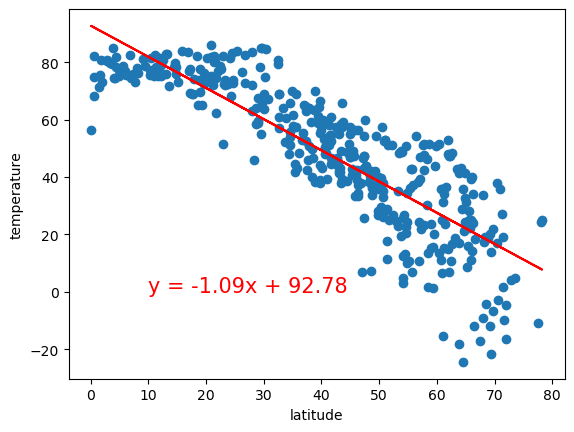

In [19]:
df2 = df.loc[df.latitude > 0].reset_index(drop=True)

# Print out the r-squared value along with the plot.
x_values = df2['latitude']
y_values = df2['temperature']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,0),fontsize=15,color="red")
plt.xlabel('latitude')
plt.ylabel('temperature')
print(f"The r-squared is: {rvalue**2}")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.3266768647996226


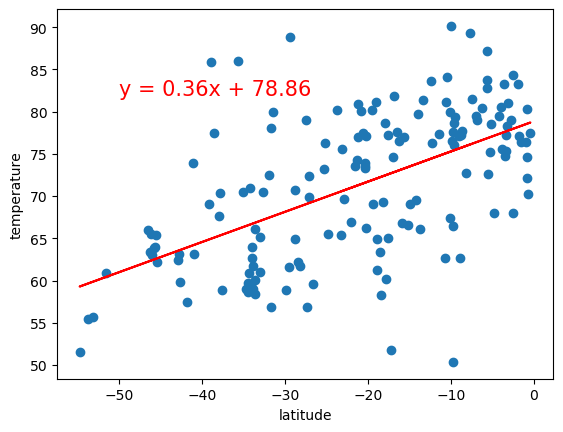

In [22]:
df2 = df.loc[df.latitude < 0].reset_index(drop=True)

# Print out the r-squared value along with the plot.
x_values = df2['latitude']
y_values = df2['temperature']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,82),fontsize=15,color="red")
plt.xlabel('latitude')
plt.ylabel('temperature')
print(f"The r-squared is: {rvalue**2}")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression